# Bonsai Demo

## Imports

In [1]:
import os
import sys

import numpy as np
import pandas as pd
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

note_dir = os.getcwd()
root_dir = os.path.dirname(note_dir)
sys.path.append(root_dir)

import bonsai
from bonsai.base import *

In [2]:
def plot_corr(corr):
    fig = plt.figure(figsize=((10,10))) # slightly larger
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr,cmap='seismic')
    fig.colorbar(cax)
    
    for (i, j), z in np.ndenumerate(corr):
        ax.text(j, i, '{:0.4f}'.format(z), ha='center', va='center', color='w')
    return 

In [3]:
def summarize_dataset(df, samples=1000, random_state=997, replace=False):
    """
    This function plots a grid of plots that give some insights into pairwise relationships between
    the attributes in the dataset.
    
    Explicit correlations or special distributions should be very visible here.
    """
    
    df_subsample = df.sample(n=samples, replace=False, random_state=random_state)
    
    sns.set(style="ticks", color_codes=True)
    g = sns.PairGrid(df_subsample) # slice every 10 otherwise a bit slow
    g = g.map_diag(plt.hist) # histograms on the diagonal
    g = g.map_lower(sns.kdeplot, cmap="Blues_d") # density plot on the lower plots
    g = g.map_upper(plt.scatter) # scatter plots on the upper plots
    return

## Demo

### Dataset

In [4]:
# Pre-built regression tree using Bonsai
X, y = make_friedman1(n_samples=10**5) 
n, m = X.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Inspection 1: Correlation Matrix

In [5]:
df = pd.DataFrame(X)
df = df.assign(y=y)
df.head()

,0,1,2,3,4,5,6,7,8,9,y
0,0.171956,0.920207,0.125482,0.350089,0.760013,0.760008,0.368858,0.317386,0.342426,0.410907,14.875103
1,0.504001,0.852461,0.173391,0.350290,0.798885,0.834631,0.999944,0.904464,0.806828,0.545055,19.387498
2,0.126547,0.310196,0.194062,0.809957,0.570638,0.149179,0.219650,0.337680,0.457211,0.350105,14.054816
3,0.076806,0.674293,0.507789,0.413759,0.764638,0.258504,0.280534,0.734519,0.001032,0.305715,9.581845
4,0.415048,0.935885,0.713387,0.041865,0.129656,0.110513,0.761270,0.316821,0.240446,0.458877,11.369677


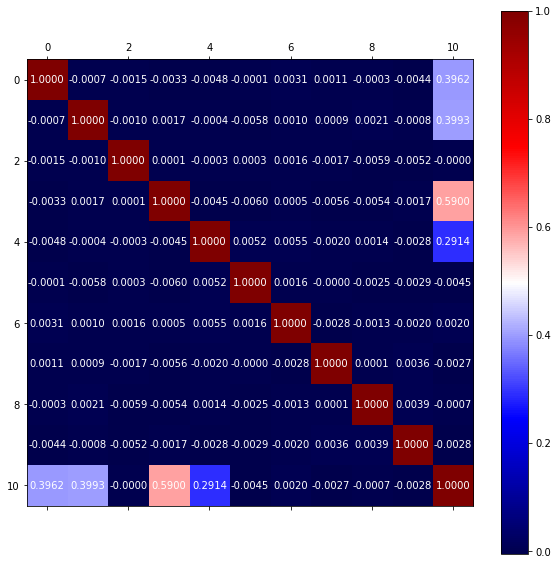

In [6]:
corr = df.corr().values
plot_corr(corr)

In [7]:
# Pandas-direct way
df_corr = pd.DataFrame(corr)
df_corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2) # 'coolwarm' & 'RdBu_r' &'BrBG' 

,0,1,2,3,4,5,6,7,8,9,10
0,1,-0.00071,-0.0015,-0.0033,-0.0048,-5.7e-05,0.0031,0.0011,-0.00032,-0.0044,0.4
1,-0.00071,1,-0.001,0.0017,-0.00038,-0.0058,0.00095,0.00086,0.0021,-0.00077,0.4
2,-0.0015,-0.001,1,5.2e-05,-0.00033,0.00032,0.0016,-0.0017,-0.0059,-0.0052,-1.5e-05
3,-0.0033,0.0017,5.2e-05,1,-0.0045,-0.006,0.00051,-0.0056,-0.0054,-0.0017,0.59
4,-0.0048,-0.00038,-0.00033,-0.0045,1,0.0052,0.0055,-0.002,0.0014,-0.0028,0.29
5,-5.7e-05,-0.0058,0.00032,-0.006,0.0052,1,0.0016,-1.2e-05,-0.0025,-0.0029,-0.0045
6,0.0031,0.00095,0.0016,0.00051,0.0055,0.0016,1,-0.0028,-0.0013,-0.002,0.002
7,0.0011,0.00086,-0.0017,-0.0056,-0.002,-1.2e-05,-0.0028,1,0.00013,0.0036,-0.0027
8,-0.00032,0.0021,-0.0059,-0.0054,0.0014,-0.0025,-0.0013,0.00013,1,0.0039,-0.00072
9,-0.0044,-0.00077,-0.0052,-0.0017,-0.0028,-0.0029,-0.002,0.0036,0.0039,1,-0.0028


### Inspection 2: Seaborn Summary

In [8]:
#summarize_dataset(df, samples=1000)

## Learn Tree

In [9]:
# Initialize
model = C45Tree(max_depth=2)

# Fit
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

rmse = np.sqrt(np.mean((y_test - y_pred)**2))
rmse

4.853038792315153

In [10]:
idxs = model.predict(X_test, output_type="index")
len(idxs)

20000

In [11]:
leaves_array = model.dump()

for leaf in leaves_array:
    n_samples = leaf['n_samples']
    val = leaf['y']
    
    msg = """
    n_samples in the leaf:  {}
    value:                  {}
    """.format(n_samples, val)
    print(msg)


    n_samples in the leaf:  13439.0
    value:                  14.447130549700887
    

    n_samples in the leaf:  26955.0
    value:                  14.411441419888247
    

    n_samples in the leaf:  20715.0
    value:                  14.392979937828013
    

    n_samples in the leaf:  18891.0
    value:                  14.445393717659677
    


In [12]:
model.dump()

[{'eqs': [{'svar': 8,
    'sval': 0.5039119920875744,
    'sidx': 2168,
    'op': '<',
    'missing': 1},
   {'svar': 7,
    'sval': 0.33594560206829305,
    'sidx': 1870,
    'op': '<',
    'missing': 1}],
  'i_start': 0,
  'i_end': 13439,
  '_id': 'ROOT::2168L::1870L',
  'n_samples': 13439.0,
  'y': 14.447130549700887,
  'depth': 2,
  'y_lst': [14.423315119337593, 14.447130549700887],
  'is_leaf': True,
  'index': 0},
 {'eqs': [{'svar': 8,
    'sval': 0.5039119920875744,
    'sidx': 2168,
    'op': '<',
    'missing': 1},
   {'svar': 7,
    'sval': 0.33594560206829305,
    'sidx': 1870,
    'op': '>=',
    'missing': 0}],
  'i_start': 13439,
  'i_end': 40394,
  '_id': 'ROOT::2168L::1870R',
  'n_samples': 26955.0,
  'y': 14.411441419888247,
  'depth': 2,
  'y_lst': [14.423315119337593, 14.411441419888247],
  'is_leaf': True,
  'index': 1},
 {'eqs': [{'svar': 8,
    'sval': 0.5039119920875744,
    'sidx': 2168,
    'op': '>=',
    'missing': 0},
   {'svar': 2,
    'sval': 0.51952807543

In [13]:
tree_ind = model.tree_ind
tree_val = model.tree_val

tree_ind

array([[-1,  8,  0,  1,  2, -1],
       [-1,  7,  0,  3,  4, -1],
       [-1,  2,  0,  5,  6, -1],
       [ 1, -1, -1, -1, -1,  0],
       [ 1, -1, -1, -1, -1,  1],
       [ 1, -1, -1, -1, -1,  2],
       [ 1, -1, -1, -1, -1,  3]])

In [14]:
tree_val

array([[ 0.50391199, -1.        ],
       [ 0.3359456 , -1.        ],
       [ 0.51952808, -1.        ],
       [-1.        , 14.44713055],
       [-1.        , 14.41144142],
       [-1.        , 14.39297994],
       [-1.        , 14.44539372]])

In [15]:
model.calculate_counts()

In [31]:
model.counts

array([[80000, 40394, 39606],
       [40394, 13439, 26955],
       [39606, 20715, 18891],
       [13439,    -1,    -1],
       [26955,    -1,    -1],
       [20715,    -1,    -1],
       [18891,    -1,    -1]])

In [32]:
model.calculate_ratios()

In [33]:
model.ratios

array([[ 0.504925  ,  0.495075  ],
       [ 0.33269793,  0.66730207],
       [ 0.52302681,  0.47697319],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        , -1.        ]])

## Count per Node

I need to know how many instances pass a node.

In [17]:
def count_samples(tree, node_idx):
    """
    Count samples for specific node in the tree.
    """
    
    tree_ind = tree.tree_ind
    tree_val = tree.tree_val
    leaves = tree.leaves
    
    def is_leaf(node_idx):
        return tree_ind[node_idx][0] == 1
    
    if is_leaf(node_idx):
        leaf_idx = tree_ind[node_idx][5]
        leaf = leaves[leaf_idx]
        return leaf['n_samples']
        
    else:
        l_idx = tree_ind[node_idx][3]
        r_idx = tree_ind[node_idx][4]
        return count_samples(tree, l_idx) + count_samples(tree, r_idx)

In [18]:
count_samples(model, 1) + count_samples(model, 2)

80000.0

In [19]:
n_samples = [count_samples(model, node_idx) for node_idx in range(len(model.tree_ind))]
n_samples

[80000.0, 40394.0, 39606.0, 13439.0, 26955.0, 20715.0, 18891.0]

## Generate DataStructure that we need

For our first, basic idea.

In [20]:
def adapt_tree_information(tree):
    tree_ind = tree.tree_ind
    tree_val = tree.tree_val
    leaves = tree.leaves
    
    n_nodes, _ = tree_ind.shape
    
    adapt_tree_int_header = ('l_idx', 'r_idx', 'l_samples', 'r_samples', 'svar')
    adapt_tree_flt_header = ('sval', 'l_ratio', 'r_ratio')
    
    adapt_tree_int = np.zeros((n_nodes, len(adapt_tree_int_header)), dtype=int)
    adapt_tree_flt = np.zeros((n_nodes, len(adapt_tree_flt_header)), dtype=float)
    
    def is_leaf(node_idx):
        return tree_ind[node_idx][0] == 1
    
    for n in range(n_nodes):
        leaf = is_leaf(n)
        
        adapt_tree_int[n, 0] = tree_ind[n][3]                               # l_idx
        adapt_tree_int[n, 1] = tree_ind[n][4]                               # r_idx
        adapt_tree_int[n, 2] = count_samples(tree, tree_ind[n][3]) if not leaf else -1 # l_samples
        adapt_tree_int[n, 3] = count_samples(tree, tree_ind[n][4]) if not leaf else -1 # r_samples
        adapt_tree_int[n, 4] = tree_ind[n][1]                               # svar
        
        adapt_tree_flt[n, 0] = tree_val[n][0]                               # sval
        
        n_samples = adapt_tree_int[n, 2] + adapt_tree_int[n, 3]
        adapt_tree_flt[n, 1] = adapt_tree_int[n, 2]/n_samples if not leaf else  -1           # l_ratio
        adapt_tree_flt[n, 2] = adapt_tree_int[n, 3]/n_samples if not leaf else  -1            # r_ratio
    
    return adapt_tree_int, adapt_tree_flt

In [21]:
def randomize_node(tree_ind, tree_val, n_idx):
    def is_leaf(node_idx):
        return tree_ind[node_idx][0] == 1
    
    return 

In [22]:
adapt_tree_information(model)

(array([[    1,     2, 40394, 39606,     8],
        [    3,     4, 13439, 26955,     7],
        [    5,     6, 20715, 18891,     2],
        [   -1,    -1,    -1,    -1,    -1],
        [   -1,    -1,    -1,    -1,    -1],
        [   -1,    -1,    -1,    -1,    -1],
        [   -1,    -1,    -1,    -1,    -1]]),
 array([[ 0.50391199,  0.504925  ,  0.495075  ],
        [ 0.3359456 ,  0.33269793,  0.66730207],
        [ 0.51952808,  0.52302681,  0.47697319],
        [-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ]]))

In [23]:
a = [1,2,3]
b = a
b[2] = 'x'

In [24]:
a

[1, 2, 'x']

In [25]:
def randomize_tree(tree):
    tree_ind = tree.tree_ind
    tree_val = tree.tree_val
    leaves = tree.leaves
    
    n_nodes, _ = tree_ind.shape
    
    sigma = 10
    mu = 0
    random_samples = np.random.normal(mu, sigma, n_nodes)
    random_samples = np.round(random_samples, decimals=0)
    
    for n in range(n_nodes):
        l_idx = tree_ind[n][3]
        r_idx = tree_ind[n][4]
        
        d = 50-l_ratio
        s = random_samples[n]
        must_swap = abs(s) > abs(d)
        
        if must_swap:
            tree_ind[n][3] = r_idx
            tree_ind[n][4] = l_idx   
            
    tree.tree_ind = tree_ind
    tree.tree_ind = tree_ind
    
    return

In [26]:
sigma = 10
mu = 0
s = np.random.normal(mu, sigma, 1000)
s = np.round(s, decimals=0)
s[:10]

array([-6.,  6.,  7., -3.,  9., 18., -2.,  3.,  4.,  7.])

In [27]:
abs(-2)

2

In [28]:
def normal_dist(x, mu=0.5, sigma=0.1):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))

In [29]:
normal_dist(0.5)

3.989422804014327

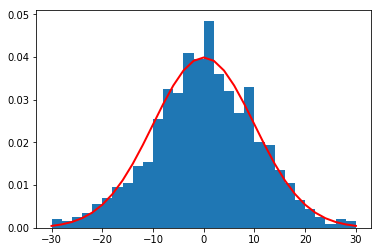

In [30]:
import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()